In [162]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
from datetime import datetime
from tqdm import tqdm
from google.cloud import bigquery

Analysis based on **LNDB.info - The Light Novel Database** (http://lndb.info)

Code confirmed working on **May 25, 2019**

In [2]:
class Crawler:
    """All the necessary pieces of code to obtain data from LNDB
    """
    def get_search_url(self,year,month):
        """LNDB's Light Novel search
        """
        search_url=\
        "http://lndb.info/releases?show=label&target_readership=undefined&only_titles=true&year={}&month={}"\
        .format(year,month)
        return search_url
    
    def get_links_by_url(self,url):
        """Find all hyperlinks the in the page given by the search url
        """
        base_url="http://lndb.info"
        try:
            res=requests.get(url,timeout=30)
        except:
            print("Page load failed")
            return
        soup = BeautifulSoup(res.text, "html.parser")
        elem_lists=soup.find_all("li",class_="releasebytitle")
        hrefs=[base_url+elem_list.a["href"] for elem_list in elem_lists]
        return hrefs
    
    def count_books_by_yearmonth(self,year,month):
        """Self-explanatory"""
        return len(self.get_links_by_url(self.get_search_url(year,month)))
    
    def count_books_by_year(self,year):
        """Self-explanatory"""
        total=0
        for month in range(1,13):
            total=total+self.count_books_by_yearmonth(year,month)
        return total
    
    def get_cover_img(self,ln_data_url):
        """Get the cover image of a light novel in binary string
        based on the url of the light novel data page
        as given by method get_links_by_url
        """
        base_url="http://lndb.info"
        try:
            res=requests.get(ln_data_url,timeout=30)
        except:
            print("Page load failed")
            return
        soup = BeautifulSoup(res.text, "html.parser")
        img_url=base_url+soup.find("div",class_="left-volume-image").img["src"]
        try:
            res=requests.get(img_url,timeout=30)
        except:
            print("Image download failed")
            return
        return res.content
    
    def show_cover_img(self,img_bin):
        """Show image based on binary of image retrieved by method get_cover_img"""
        plt.figure(figsize=(10,10))
        with Image.open(BytesIO(img_bin)) as img:
            plt.imshow(img)
            
    def get_img_dim(self,img_bin):
        """Get the width and height of binary image.
        Returns (width,height)"""
        with Image.open(BytesIO(img_bin)) as img:
            width=img.size[0]
            height=img.size[1]
            return width,height
        
    def get_novel_info(self,url):
        """Extract information of light novel from light novel data page url"""
        try:
            res=requests.get(url,timeout=30)
        except:
            print("Page load failed")
            return
        soup = BeautifulSoup(res.text, "html.parser")
        elems_label=soup.find_all("td",class_="secondary-volume-info-title")
        list_label=[elem_label.text.strip() for elem_label in elems_label]
        try:
            idx=list_label.index("ISBN-13")
            isbn=elems_label[idx].find_next_sibling("td").text.strip()
        except:
            isbn=np.nan
        try:
            idx=list_label.index("Illustrator")
            illustrator=elems_label[idx].find_next_sibling("td").text.strip()
        except:
            illustrator=np.nan
        try:
            idx=list_label.index("Japanese Volume Title")
            title=elems_label[idx].find_next_sibling("td").text.strip()
        except:
            title=np.nan
        try:
            idx=list_label.index("Volume")
            volumn=elems_label[idx].find_next_sibling("td").text.strip()
        except:
            volumn=np.nan
        try:
            idx=list_label.index("Release Date")
            date=elems_label[idx].find_next_sibling("td").text.strip()
        except:
            date=np.nan
        dt_date=datetime.strptime(date, "%B %d, %Y")
        year=dt_date.year
        month=dt_date.month
        return {"isbn":isbn, "year":year, "month":month, "title":title, "volumn":volumn, "illustrator":illustrator}

In [150]:
class Analyzer:
    """Analysis utilities based on Crawler"""
    def get_cover_data(self,url):
        """Get a dictionary with light novel information and cover image by the url of the light novel data page"""
        crawler=Crawler()
        info=crawler.get_novel_info(url)
        cover=crawler.get_cover_img(url)
        return {**info,"cover":cover}
        
    def get_cover_df(self,year,month):
        """Get the dataframe containing all the cover data for light novels published in year,month"""
        crawler=Crawler()
        urls=crawler.get_links_by_url(crawler.get_search_url(year,month))
        data_df={"ISBN":[],"PublishYear":[],"PublishMonth":[],"Title":[],"Volumn":[],"Illustrator":[],"Cover":[]}
        print("Gathering novel data published in {}/{}".format(year,month),flush=True)
        with tqdm(total=len(urls)) as bar:
            for url in urls:
                cover_data=self.get_cover_data(url)
                data_df["ISBN"].append(cover_data["isbn"])
                data_df["PublishYear"].append(cover_data["year"])
                data_df["PublishMonth"].append(cover_data["month"])
                data_df["Title"].append(cover_data["title"])
                data_df["Volumn"].append(cover_data["volumn"])
                data_df["Illustrator"].append(cover_data["illustrator"])
                data_df["Cover"].append(cover_data["cover"])
                bar.update(1)
        df=pd.DataFrame(data_df,columns=["ISBN","PublishYear","PublishMonth","Title","Volumn","Illustrator","Cover"])
        return df
    
    def imshow(self,img_bin):
        """Show image based on binary string of image retrieved by method get_cover_img"""
        plt.figure(figsize=(10,10))
        with Image.open(BytesIO(img_bin)) as img:
            plt.imshow(img)
    
    def get_cover_df_year(self,year):
        """Get the dataframe containing all cover data for light novels published in year"""
        dfs=[]
        for month in range(1,13):
            df_temp=self.get_cover_df(year,month)
            dfs.append(df_temp)
        df_combined=pd.concat(dfs,axis=0,ignore_index=True)
        return df_combined
    
    def cover2array(self,img_bin):
        """Returns the numpy array representation of binary cover image string"""
        with Image.open(BytesIO(img_bin)) as img:
            return np.array(img)
        
    def get_dominant_colors(self,img,ncluster=8):
        """Get dominant colors of cover image by obtaining centroids with k-means clustering.
        Input is binary image string. ncluster is k in k-means.
        Returns integer centroids ordered by importance in descending order."""
        img=self.cover2array(img)
        img=img.reshape((-1,3))
        Z = np.float32(img)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        ret,label,center=cv2.kmeans(Z,ncluster,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
        series_label=pd.Series(label.reshape((-1)))
        idx=series_label.value_counts().index
        importance=series_label.value_counts().values/len(label)*100
        return importance,center[idx].astype(int)

In [4]:
analyzer=Analyzer()
df=analyzer.get_cover_df_year(2018)

Gathering novel data published in 2018/1


100%|██████████| 54/54 [00:34<00:00,  1.55it/s]


Gathering novel data published in 2018/2


100%|██████████| 64/64 [00:44<00:00,  1.55it/s]


Gathering novel data published in 2018/3


100%|██████████| 47/47 [00:33<00:00,  1.29it/s]


Gathering novel data published in 2018/5


100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


Gathering novel data published in 2018/6


 97%|█████████▋| 58/60 [00:45<00:01,  1.33it/s]


Gathering novel data published in 2018/7


100%|██████████| 54/54 [00:38<00:00,  1.31it/s]


Gathering novel data published in 2018/8


100%|██████████| 40/40 [00:27<00:00,  1.44it/s]


Gathering novel data published in 2018/9


100%|██████████| 45/45 [00:35<00:00,  1.13it/s]


Gathering novel data published in 2018/10


100%|██████████| 54/54 [00:37<00:00,  1.44it/s]


Gathering novel data published in 2018/11


100%|██████████| 44/44 [00:39<00:00,  1.34it/s]


Gathering novel data published in 2018/12


100%|██████████| 49/49 [00:40<00:00,  1.35it/s]


In [5]:
df

ISBN  PublishYear  PublishMonth  \
0    978-4434241994         2018             1   
1    978-4434242175         2018             1   
2    978-4434241987         2018             1   
3    978-4086312257         2018             1   
4    978-4048935722         2018             1   
5    978-4048935784         2018             1   
6    978-4048935944         2018             1   
7    978-4048935876         2018             1   
8    978-4040725703         2018             1   
9    978-4803011494         2018             1   
10   978-4803011517         2018             1   
11   978-4040723709         2018             1   
12   978-4040723037         2018             1   
13   978-4040708973         2018             1   
14   978-4040723051         2018             1   
15   978-4040724270         2018             1   
16   978-4040725765         2018             1   
17   978-4797393866         2018             1   
18   978-4797395501         2018             1   
19   978-4896376883         2018             1   
20   978-4094517170         2018             1   
21   978-4798616049         2018             1   
22   978-4798616223         2018             1   
23   978-4798616209         2018             1   
24   978-4798615578         2018             1   
25   978-4150313135         2018             1   
26   978-4150313142         2018             1   
27   978-4041062821         2018             1   
28   978-4062208758         2018             1   
29   978-4040696645         2018             1   
..              ...          ...           ...   
617  978-4798618210         2018            12   
618  978-4798618449         2018            12   
619  978-4798618258         2018            12   
620  978-4798618432         2018            12   
621  978-4074363582         2018            12   
622  978-4408554563         2018            12   
623  978-4040729923         2018            12   
624  978-4040726984         2018            12   
625  978-4041065235         2018            12   
626  978-4041076781         2018            12   
627  978-4041075494         2018            12   
628  978-4041070819         2018            12   
629  978-4040653891         2018            12   
630  978-4040651347         2018            12   
631  978-4040653877         2018            12   
632  978-4040652948         2018            12   
633  978-4040653020         2018            12   
634  978-4040653815         2018            12   
635  978-4040653808         2018            12   
636  978-4575752342         2018            12   
637  978-4865544282         2018            12   
638  978-4865544299         2018            12   
639  978-4865544312         2018            12   
640  978-4865292954         2018            12   
641  978-4065138243         2018            12   
642  978-4864727617         2018            12   
643             NaN         2018            12   
644  978-4864727648         2018            12   
645             NaN         2018            12   
646  978-4086312844         2018            12   

                                                 Title Volumn  \
0                                           白の皇国物語〈20〉     20   
1                                THE NEW GATE〈11〉蒼海の水底     11   
2                                    元構造解析研究者の異世界冒険譚 2      2   
3    若者の黒魔法離れが深刻ですが、就職してみたら待遇いいし、社長も使い魔もかわいくて最高です！ ...      3   
4                                          はたらく魔王さま!18     18   
5                          ストライク・ザ・ブラッド APPEND１ 人形師の遺産      1   
6                   ソードアート・オンライン オルタナティブ クローバーズ・リグレット2      2   
7                                          賭博師は祈らない(3)      3   
8              トリニティセブン　７人の魔書使い　The Novel 聖なる巫女と八番目の書庫      3   
9                 即死チートが最強すぎて、異世界のやつらがまるで相手にならないんですが。４      4   
10                             その者。のちに…07　別世界・四大魔王編（下）      7   
11                              ゲーマーズ!9 雨野景太と青春スキルリセット      9   
12                       非オタの彼女が俺の持ってるエロゲに興味津々なんだが…… 7      7   
13  

In [9]:
# Store table on GCP BigQuery
client = bigquery.Client(location="US")
dataset = client.get_dataset('light_novel_covers')
table_ref = dataset.table("covers")
job = client.load_table_from_dataframe(df, table_ref, location="US")

job.result()  # Waits for table load to complete.

In [10]:
df_orig=df.copy()

In [16]:
df.memory_usage(deep=True).sum()/1024/1024

44.663387298583984

In [17]:
df["Size"]=df["Cover"].apply(len)

(array([ 6.,  5.,  6.,  9., 13., 23., 32., 51., 63., 76., 69., 85., 72.,
        38., 40., 27., 12., 11.,  6.,  3.]),
 array([41356. , 44285.1, 47214.2, 50143.3, 53072.4, 56001.5, 58930.6,
        61859.7, 64788.8, 67717.9, 70647. , 73576.1, 76505.2, 79434.3,
        82363.4, 85292.5, 88221.6, 91150.7, 94079.8, 97008.9, 99938. ]),
 <a list of 20 Patch objects>)

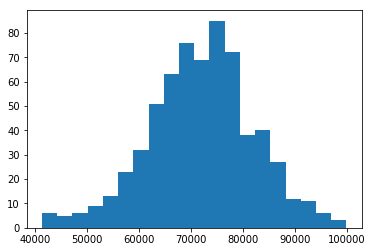

In [21]:
plt.hist(df["Size"],bins=20)

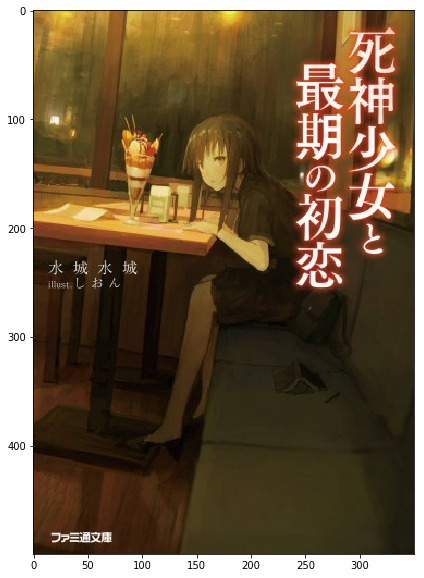

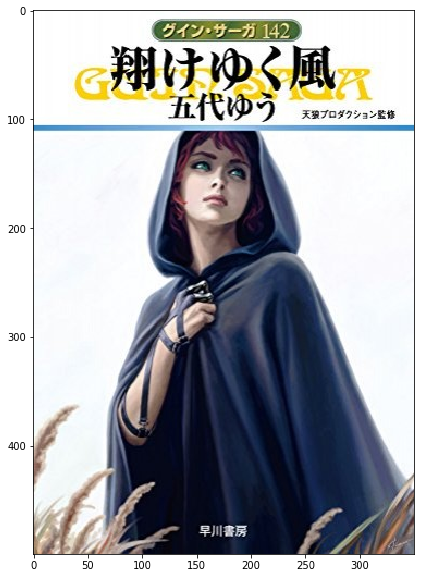

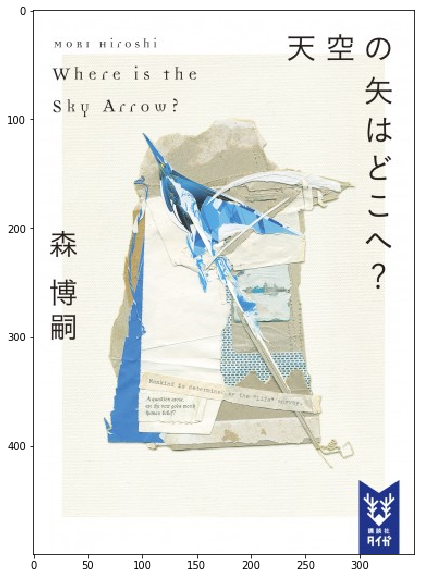

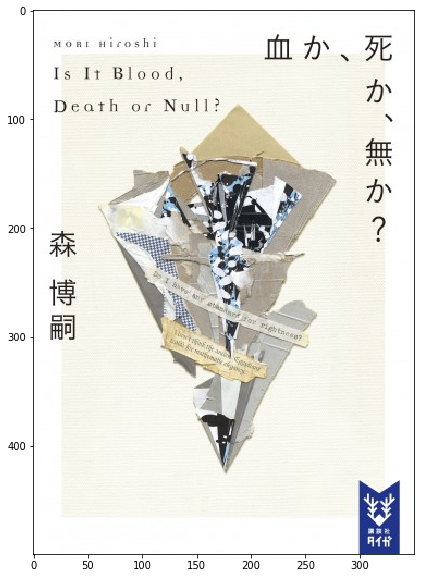

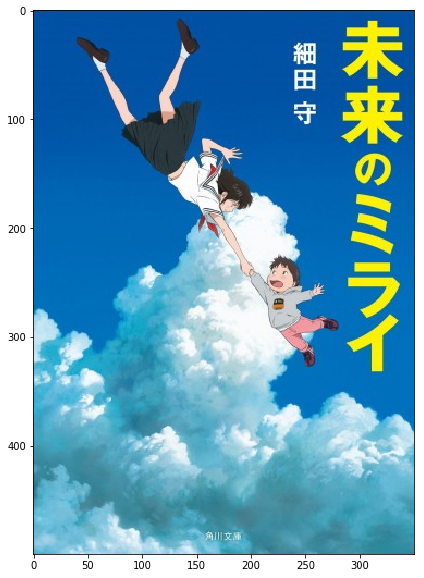

In [125]:
# Five of the most "spartan" covers
for cover in df.sort_values(by="Size").head()["Cover"].values:
    analyzer.show_cover_img(cover)

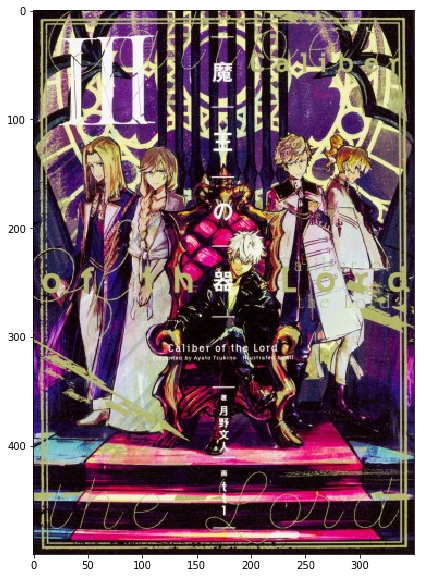

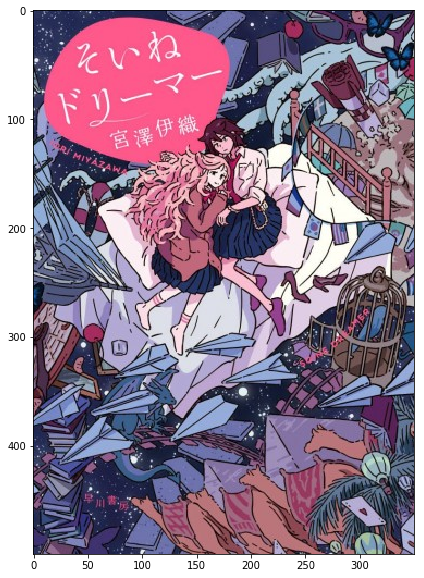

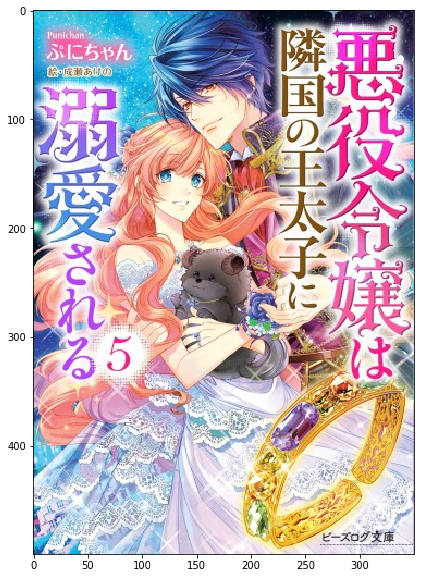

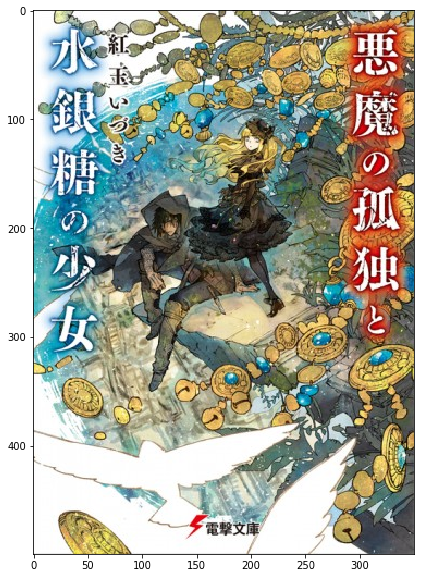

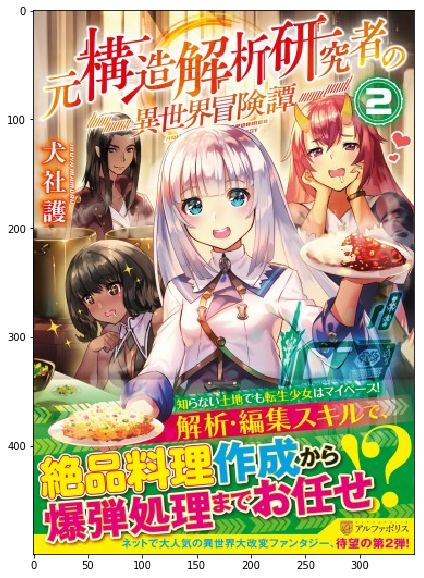

In [126]:
# Five of the most "baroque" covers
for cover in df.sort_values(by="Size").tail()["Cover"].values:
    analyzer.show_cover_img(cover)

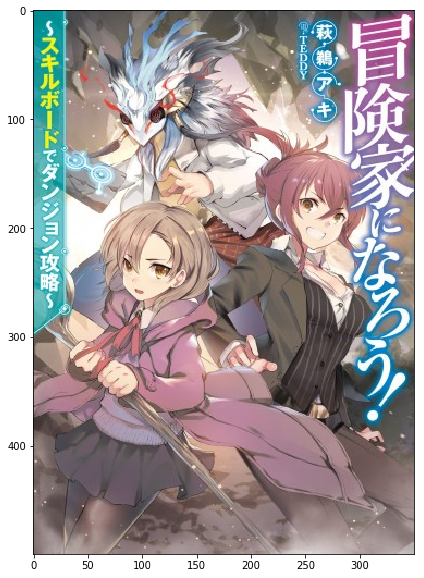

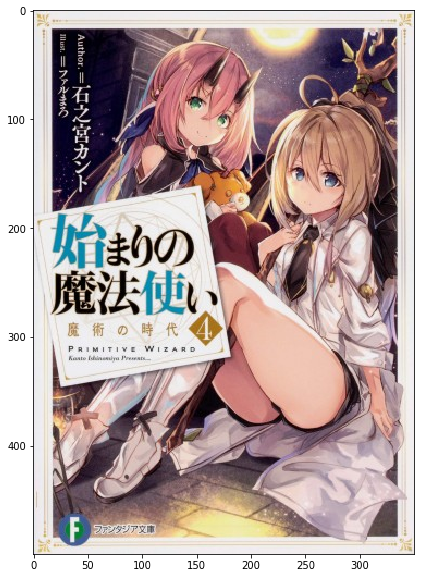

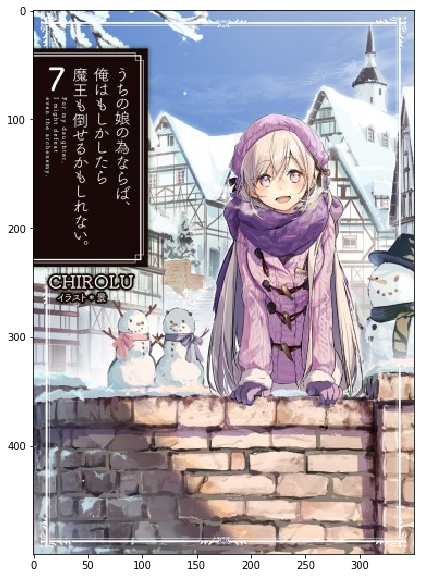

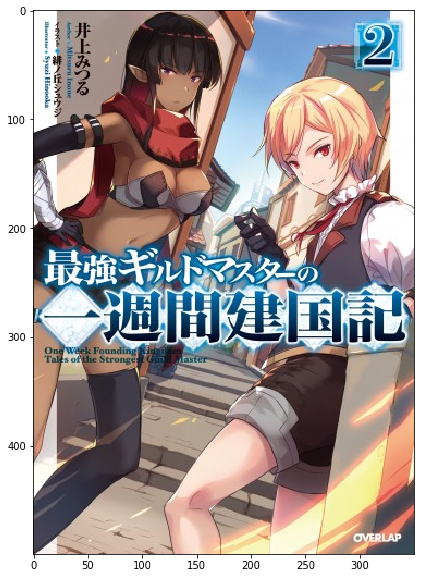

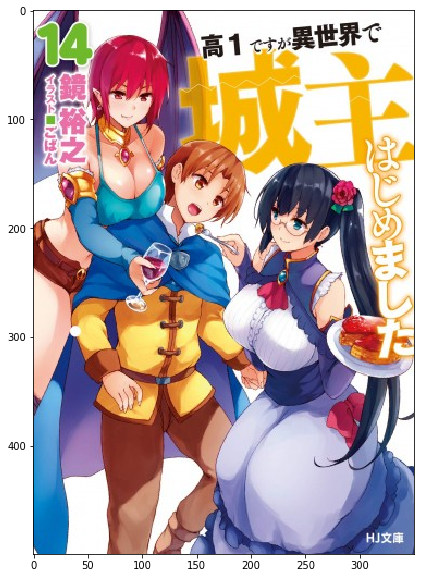

In [130]:
# Middle ground
df_middle=df.copy()
mean=df_middle["Size"].mean()
df_middle["Score"]=np.abs(df_middle["Size"]-mean)
for cover in df_middle.sort_values(by="Score").head()["Cover"].values:
    analyzer.show_cover_img(cover)

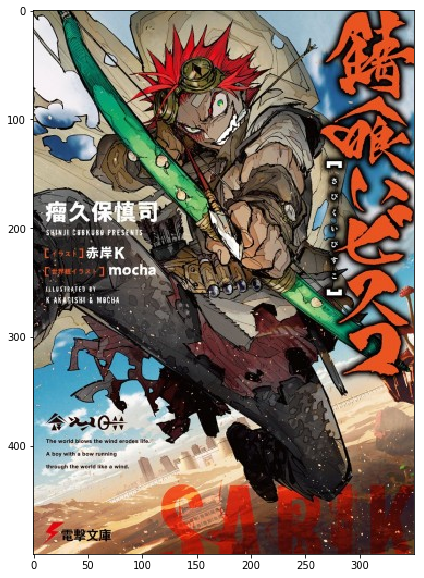

[21.80628571 18.24228571 15.46857143 14.68171429 12.01371429  7.792
  6.17485714  3.82057143]


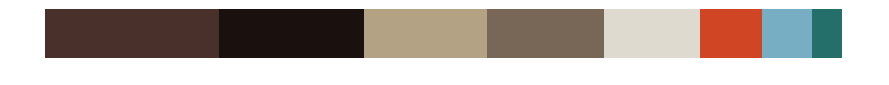

In [207]:
cover=df["Cover"][np.random.randint(df.shape[0])]
analyzer=Analyzer()
ncluster=8
importance,colors=analyzer.get_dominant_colors(cover)
analyzer.imshow(cover)
plt.show()
print(importance)
plt.figure(figsize=(15,1))
for i in range(ncluster):
    if i==0:
        plt.barh(0, importance[i],color=colors[i]/255.0)
    else:
        plt.barh(0, importance[i],left=np.sum(importance[:i]),color=colors[i]/255.0)

plt.axis("off")
plt.show()